Using code from [MedicalZooPytorch](https://github.com/black0017/MedicalZooPytorch)

In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage

## Data paths and cv-split

In [2]:
fold = 0
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df_train = df[df.fold != fold]
df_val = df[df.fold == fold]

df_train.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
5,8,1,3


In [3]:
npy_dir = '../input/registered_cases/train/'
sample_fns_train = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_train.BraTS21ID.values]
lbls_train = list(df_train.MGMT_value.values)

sample_fns_val = [os.path.join(npy_dir, str(_id).zfill(5) + '.npy') for _id in df_val.BraTS21ID.values]
lbls_val = list(df_val.MGMT_value.values)

## 3D MRI augmentations

In [4]:
class RandomChoice(object):
    """
    choose a random tranform from list an apply
    transforms: tranforms to apply
    p: probability
    """

    def __init__(self, transforms=[],
                 p=0.5):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        t = random.choice(self.transforms)
        return t(sample)
    
class ComposeTransforms(object):
    """
    Composes several transforms together.
    """

    def __init__(self, transforms=[],
                 p=0.9):
        self.transforms = transforms
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        for t in self.transforms:
            sample = t(sample)
        return sample
    
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage.filters import gaussian_filter

def stack_seg_2_image(sample):
    image = sample['image']
    seg = sample['segmentation']
    channels = [chan for chan in image]
    channels.append(seg)
    return np.stack(channels, axis=3)

def elastic_transform_3d(sample, alpha=1, sigma=20, c_val=0.0, method="linear"):
    """
    :param sample: dict of image and seg
    :param alpha: scaling factor of gaussian filter
    :param sigma: standard deviation of random gaussian filter
    :param c_val: fill value
    :param method: interpolation method. supported methods : ("linear", "nearest")
    :return: deformed image and/or label
    """
    img_numpy = sample['image'].copy()
    label = sample['segmentation'] if 'segmentation' in sample else None
    shape = img_numpy.shape
    
    # Define 3D coordinate system
    coords = np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2])

    # Interpolated images
    chan_intrps = [RegularGridInterpolator(coords, img_numpy[:,:,:,chan],
                                        method=method,
                                        bounds_error=False,
                                        fill_value=c_val) for chan in range(shape[3])]

    #Get random elastic deformations
    dx = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dy = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dz = gaussian_filter((np.random.rand(shape[0],shape[1],shape[2]) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha

    # Define sample points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]

    indices = np.reshape(x + dx, (-1, 1)), \
              np.reshape(y + dy, (-1, 1)), \
              np.reshape(z + dz, (-1, 1))

    # Interpolate 3D image image
    img_numpy = np.stack([chan_intrp(indices).reshape((shape[0],shape[1],shape[2])) 
                          for chan_intrp in chan_intrps], axis=3).astype(np.float32)

    # Interpolate labels
    if label is not None:
        lab_intrp = RegularGridInterpolator(coords, label,
                                            method="nearest",
                                            bounds_error=False,
                                            fill_value=0)

        label = lab_intrp(indices).reshape(shape[0],shape[1],shape[2]).astype(label.dtype)
        sample['segmentation'] = label
    
    sample['image'] = img_numpy
    return sample


class ElasticTransform(object):
    def __init__(self, p=0.5, alpha=1, sigma=20, c_val=0.0, method="linear"):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
        self.c_val = c_val
        self.method = method

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return elastic_transform_3d(sample, self.alpha, self.sigma, self.c_val, self.method)
    
def random_noise(sample, mean=0, std=0.001, eps=1e-6):
    im = sample['image'].copy()
    noise = np.random.normal(mean, std, im.shape)
    sample['image'] = np.where(im > eps, im + noise, im)
    return sample


class GaussianNoise(object):
    def __init__(self, p=0.5, mean=0, std=0.001):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        
        return random_noise(sample, self.mean, self.std)
    
def random_crop_to_size(sample, crop_sz):
    
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    shape = im.shape
    
    width, height, depth = crop_sz
    d = np.random.randint(0, shape[0] - depth - 1)
    x = np.random.randint(0, shape[1] - width - 1)
    y = np.random.randint(0, shape[2] - height - 1)
    
    im = im[d:d+depth, x:x+width, y:y+height,:]
    seg = seg[d:d+depth, x:x+width, y:y+height]
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample

class RandomCropToSize(object):
    
    def __init__(self, crop_sz=(200,200,95)):
        self.crop_sz = crop_sz

    def __call__(self, sample):
        return random_crop_to_size(sample, self.crop_sz)
    
def random_flip_lr(sample):
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    im = im[:,:,::-1,:]
    seg = seg[:,:,::-1]
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample

class RandomFlipLR(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_flip_lr(sample)

def random_channel_drop(sample):
    im = sample['image'].copy()
    c = im.shape[3]
    drop_ch = random.randint(0, c-1)
    im[:,:,:,drop_ch] = 0. if random.random() > 0.5 else 1.0
    sample['image'] = im
    return sample
    
class RandomChannelDrop(object):
    def __init__(self, p=0.05):
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_channel_drop(sample)

def random_rotate3D(sample, min_angle, max_angle):
    """
    Returns a random rotated image and seg map in sample dict
    :param sample: ds sample dict
    :param min_angle: in degrees
    :param max_angle: in degrees
    :return: sample
    """
    im = sample['image'].copy()
    seg = sample['segmentation'].copy()
    assert min_angle < max_angle, "min should be less than max val"
    assert min_angle > -360 or max_angle < 360
    all_axes = [(1, 0), (1, 2), (0, 2)]
    
    angle = np.random.randint(low=min_angle, high=max_angle + 1)
    axes_random_id = np.random.randint(low=0, high=len(all_axes))
    axes = all_axes[axes_random_id]
    
    im = ndimage.interpolation.rotate(im , angle, axes=axes, reshape=False)
    
    seg = ndimage.rotate(seg.astype(np.float32), angle, axes=axes, reshape=False)
    
    # seg back to binary float values
    seg = np.where(seg < 0.5, 0, 1.)
    
    sample['image'] = im
    sample['segmentation'] = seg
    
    return sample


class RandomRotation(object):
    def __init__(self, min_angle=-10, max_angle=10, p=0.5):
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.p = p

    def __call__(self, sample):
        augment = np.random.random(1) < self.p
        if not augment:
            return sample
        return random_rotate3D(sample, self.min_angle, self.max_angle)

## Dataset

In [28]:
class BraTS2021(Dataset):
    """
    Dataset for BraTS2021 challenge - Includes tasks 1 and 2
    """

    def __init__(self, mode, 
                 npy_fns_list,
                 label_list=[],
                 augmentations=None,
                 volume_normalize=True,
                 segmentation_classes=True,
                 max_out_size=(256,256,96)
                ):
        """
        :param mode: 'train','val','test'
        :param npy_fns_list: list of numpy array paths
        :param label_list: list of binary label integers
        :param augmentations: 3D augmentations
        :param volume_normalize: z-score normalize each channel in sample
        :param segmentation_classes: use two tumor segmentation classes for No-MGMT and MGMT 
        :param max_out_size: max out dimensions (x,y,z), if data is larger, it is cropped to this
        """
        self.mode = mode
        self.augmentations = augmentations
        self.volume_normalize = volume_normalize
        self.segmentation_classes = segmentation_classes
        self.max_out_size = max_out_size
        
        self.seg_fn_list = []
        self.fn_list = npy_fns_list
        self.label_list = label_list
        
        if self.mode != "test":
            fn_list_with_seg = []
            label_list_with_seg = []
            for fn, lbl in zip(npy_fns_list, label_list):
                fn_seg = str(fn).replace('.npy', '_seg.npy')
                if os.path.exists(fn_seg) and os.path.exists(fn):
                    fn_list_with_seg.append(fn)
                    self.seg_fn_list.append(fn_seg)
                    label_list_with_seg.append(int(lbl))
            
            # update fn list and exclude ones that don't have seg map
            self.fn_list = fn_list_with_seg
            self.label_list = label_list_with_seg
            assert len(self.fn_list) == len(self.seg_fn_list) == len(self.label_list)
        
        ########################
        #### Sanity checks #####
        
        assert len(self.fn_list) > 0
        
        # Check one sample
        one_sample = np.load(self.fn_list[0])
        assert len(one_sample.shape) == 4
        d,x,y,c = one_sample.shape
        self.full_vol_dim = (x,y,d)
        self.channels = c
        
        # Check one seg map
        if len(self.seg_fn_list) > 0:
            one_seg_sample = np.load(self.seg_fn_list[0])
            assert len(one_seg_sample.shape) == 3
            seg_d,seg_x,seg_y = one_seg_sample.shape
            assert seg_d == d
            assert seg_x == x
            assert seg_y == y
            
        #### Sanity checks #####
        ########################
        
        # shuffle samples
        if self.mode != "test":
            all_lists = list(zip(self.fn_list, self.seg_fn_list, self.label_list))
            random.shuffle(all_lists)
            self.fn_list, self.seg_fn_list, self.label_list = zip(*all_lists)
        
    def __len__(self):
        return len(self.fn_list)

    def __getitem__(self, index):
        sample = np.load(self.fn_list[index]).astype(np.float32)
        out_dict = {
            'BraTSID' : int(os.path.basename(self.fn_list[index]).split('.')[0]),
            'image' : sample
        }
        
        # Labels and augmentations
        if self.mode != "test":
            seg = np.load(self.seg_fn_list[index])
            # set seg to binary values
            seg = (seg > 0).astype(np.float32)
            lbl = self.label_list[index]
            out_dict['segmentation'] = seg 
            out_dict['label'] = lbl
            
            if self.augmentations:
                out_dict = self.augmentations(out_dict)
            
            
            if self.segmentation_classes:
                # split segmentation to two
                empty_seg = np.zeros_like(out_dict['segmentation'])
                if lbl == 0:
                    out_dict['segmentation'] = np.stack([out_dict['segmentation'], empty_seg], axis=3)
                else:
                    out_dict['segmentation'] = np.stack([empty_seg, out_dict['segmentation']], axis=3)
            else:
                # Add channel dimension to segmentation
                out_dict['segmentation'] = np.expand_dims(out_dict['segmentation'], axis=3)
            
            # swap channel axis in image with depth axis - torch wants channel first
            out_dict['segmentation'] = np.swapaxes(out_dict['segmentation'], 0, 3)
        
        # z-score norm each channel - done after augmentations
        if self.volume_normalize:
            sample = out_dict['image']
            sample_mean = np.mean(sample, axis=tuple([0,1,2]))
            sample_std = np.std(sample, axis=tuple([0,1,2])) + 1e-6
            sample = (sample - sample_mean) / sample_std
            out_dict['image'] = sample
            out_dict['mean'] = sample_mean
            out_dict['std'] = sample_std
        else:
            out_dict['mean'] = np.array([0 for _ in range(sample.shape[3])])
            out_dict['std'] = np.array([1. for _ in range(sample.shape[3])])
        
        # swap channel axis in image with depth axis - torch wants channel first
        out_dict['image'] = np.swapaxes(out_dict['image'], 0, 3)
        
        # check that size doesn't exceed max size
        im_shape = list(out_dict['image'].shape[1:])
        for i, max_sz in enumerate(self.max_out_size):
            im_shape[i] = min(im_shape[i], max_sz)
        out_dict['image'] = out_dict['image'][:,:im_shape[0],:im_shape[1],:im_shape[2]]
        if 'segmentation' in out_dict:
            out_dict['segmentation'] = out_dict['segmentation'][:,:im_shape[0],:im_shape[1],:im_shape[2]]
        
        # convert values to torch and arrays
        for key, val in out_dict.items():
            if key == 'label':
                out_dict[key] = np.array(val)
            elif key == 'BraTSID':
                out_dict[key] = np.array(val)
            else:
                out_dict[key] = torch.FloatTensor(val.copy())
            
        return out_dict

In [29]:
crop_sz = (192,192,96)

augmentations = ComposeTransforms([
    ElasticTransform(p=0.1),
    RandomRotation(p=0.5),
    RandomCropToSize(crop_sz=crop_sz),
    GaussianNoise(p=0.2, mean=0, std=0.001),
    RandomFlipLR(p=0.5),
    RandomChannelDrop(p=0.01),
], p=1.0)

train_ds = BraTS2021(
    mode='train', 
    npy_fns_list=sample_fns_train, 
    label_list=lbls_train,
    augmentations=augmentations,
    volume_normalize=True
)

val_ds = BraTS2021(
    mode='val', 
    npy_fns_list=sample_fns_val, 
    label_list=lbls_val,
    augmentations=None,
    volume_normalize=True
)

In [30]:
%%time
sample = train_ds.__getitem__(1)

CPU times: user 373 ms, sys: 193 ms, total: 566 ms
Wall time: 783 ms


In [8]:
img = sample['image']
img.shape

torch.Size([3, 192, 192, 96])

In [31]:
val_ds.__getitem__(1)['image'].shape

torch.Size([3, 256, 256, 96])

In [9]:
sample['segmentation'].shape

torch.Size([2, 192, 192, 96])

## Visualization

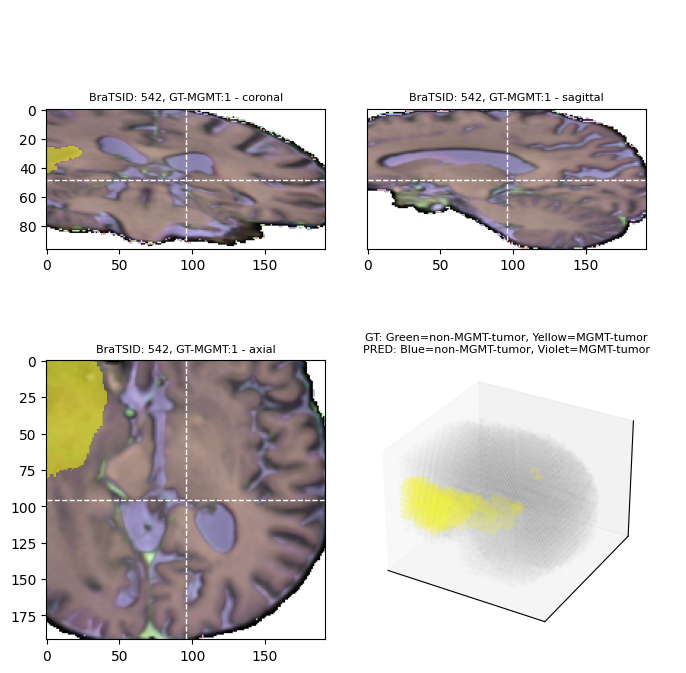

In [10]:
def make_bg_transparent(im, bg_th=0.0, set_to_color=None):
    # create transparency alpha channel
    # convert image to RGBA
    if len(im.shape) == 3:
        alpha_c = (np.sum(im[:,:,:],axis=2) > bg_th).astype(im.dtype)
        c1,c2,c3 = cv2.split(im)
    else:
        alpha_c = (im[:,:] > bg_th).astype(im.dtype)
        c1,c2,c3 = im.copy(), im.copy(), im.copy()
    if set_to_color is not None:
        zeros = np.zeros_like(c1)
        if set_to_color == 'green':
            merged = np.stack([zeros,c2,zeros,alpha_c], axis=-1)
        elif set_to_color == 'red':
            merged = np.stack([zeros,zeros,c3,alpha_c], axis=-1)
        elif set_to_color == 'royalblue':
            merged = np.stack([c1,zeros,zeros,alpha_c], axis=-1)
        elif set_to_color == 'violet':
            merged = np.stack([c1,zeros,c3,alpha_c], axis=-1)
        elif set_to_color == 'yellow':
            merged = np.stack([c1,c2,zeros,alpha_c], axis=-1)
    else:
        merged = np.stack([c1,c2,c3,alpha_c], axis=-1)
    return merged

def to_3d_points(im, th=1e-6, downsample=5):
    xs,ys,ds = [],[],[]
    if len(im.shape) == 4:
        im3d = np.sum(im,axis=3)
    else:
        im3d = im
    depth,width,height = im3d.shape
    step_vol = downsample**3
    for x in range(0, width - downsample, downsample):
        for y in range(0, height - downsample, downsample):
            for d in range(0, depth - downsample, downsample):
                if (np.sum(im3d[d:d+downsample, x:x+downsample, y:y+downsample]) / step_vol) > th:
                    xs.append(x + (downsample//2))
                    ys.append(y + (downsample//2))
                    ds.append(d + (downsample//2))
    return np.array(xs), np.array(ys), np.array(ds)

def adjust_saturation(img, sat_scale=0.3):
    hsv_im = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    (h, s, v) = cv2.split(hsv_im)
    s = s*sat_scale
    s = np.clip(s,0,255)
    hsv_im = np.stack([h,s,v],axis=2).astype(np.uint8)
    return cv2.cvtColor(hsv_im, cv2.COLOR_HSV2RGB) / 255.

def show_mri_sample(sample, pred_mask=None, pred_lbl=None):
    """ Plot sample in three projections """
    plt.close('all')
    
    alpha=0.5
    image_alpha=1.0
    
    ims = sample['image'].numpy()
    means = sample['mean'].numpy()
    stds = sample['std'].numpy()
    segs = sample['segmentation'].numpy() if 'segmentation' in sample else None
    
    # add batch dims if missing
    if ims.ndim == 4:
        ims = np.expand_dims(ims, 0)
        means = np.expand_dims(means, 0)
        stds = np.expand_dims(stds, 0)
        if segs is not None:
            segs = np.expand_dims(segs, 0)
    
    n_images = len(ims)
    n_root = int(np.ceil(np.sqrt(n_images)))
    n_cols = n_root * 2
    n_rows = n_root * 2
    
    fig_scale = 3
    f = plt.figure(figsize=(fig_scale*n_cols,fig_scale*n_rows))
    
    # Read additional meta from batch
    brats_ids = [sample['BraTSID']] if n_images == 1 else sample['BraTSID']
    labels = None
    if 'label' in sample:
        labels = [sample['label']] if n_images == 1 else sample['label']
    
    def _subplot_index(index, row_off, col_off):
        startrow = (index * 2)//n_cols
        startcol = (index * 2)%n_cols
        return (2*startrow+row_off)*n_cols + (startcol + col_off) + 1
    
    for index in range(n_images):
        im = ims[index]
        seg = segs[index]
        seg = np.swapaxes(seg, 0,3)
        # Normalize images for visualization
        im = np.swapaxes(im, 0,3) # swap depth and chan axes
        im = (im * stds[index]) + means[index]
    
        title = f'BraTSID: {brats_ids[index]}'
        if labels is not None:
            title += f', GT-MGMT:{labels[index]}'
        if pred_lbl is not None:
            title += f', Pred-MGMT:{pred_lbl[index]}'
    
        d,x,y,c = im.shape
        
        coronal_ax = f.add_subplot(n_rows,n_cols, _subplot_index(index,0,0))
        coronal_ax.set_title(title + ' - coronal', fontsize=8)
        coronal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,x//2,:,:])), alpha=image_alpha)
    
        sagittal_ax = f.add_subplot(n_rows,n_cols,_subplot_index(index,0,1))
        sagittal_ax.set_title(title + ' - sagittal', fontsize=8)
        sagittal_ax.get_yaxis().set_visible(False)
        sagittal_ax.imshow(make_bg_transparent(adjust_saturation(im[::-1,:,y//2,:])), alpha=image_alpha)
    
        axial_ax = f.add_subplot(n_rows,n_cols,_subplot_index(index,1,0))
        axial_ax.set_title(title + ' - axial', fontsize=8)
        axial_ax.imshow(make_bg_transparent(adjust_saturation(im[d//2,:,:,:])), alpha=image_alpha)
    
        proj_ax = f.add_subplot(n_rows, n_cols, _subplot_index(index,1,1), projection='3d')
        proj_ax.scatter(*to_3d_points(im), color='gray', alpha=0.015, s=5, depthshade=False)
        proj_ax.set_title('GT: Green=non-MGMT-tumor, Yellow=MGMT-tumor\nPRED: Blue=non-MGMT-tumor, Violet=MGMT-tumor', fontsize=8)
        proj_ax.set_xticks([])                               
        proj_ax.set_yticks([])                               
        proj_ax.set_zticks([])
    
        if seg is not None:
            for seg_chan, color in zip(range(seg.shape[0]),['green','yellow']):
                coronal_ax.imshow(make_bg_transparent(seg[::-1,x//2,:,seg_chan], set_to_color=color), alpha=alpha)
                sagittal_ax.imshow(make_bg_transparent(seg[::-1,:,y//2,seg_chan], set_to_color=color), alpha=alpha)
                axial_ax.imshow(make_bg_transparent(seg[d//2,:,:,seg_chan], set_to_color=color), alpha=alpha)
                proj_ax.scatter(*to_3d_points(seg[:,:,:,seg_chan]), color=color, s=5, alpha=0.1)
    
        if pred_mask is not None:
            pred = np.swapaxes(pred_mask[index].cpu().numpy(), 0,3)
            pred = np.clip(pred, 0, 1.)
            for seg_chan, color in zip(range(pred.shape[3]),['royalblue','violet']):
                coronal_ax.imshow(make_bg_transparent(pred[::-1,x//2,:, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                sagittal_ax.imshow(make_bg_transparent(pred[::-1,:,y//2, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                axial_ax.imshow(make_bg_transparent(pred[d//2,:,:, seg_chan], set_to_color=color, bg_th=0.5), alpha=alpha)
                proj_ax.scatter(*to_3d_points(pred[:,:,:,seg_chan], th=0.5), color=color, s=5, alpha=0.1)
        
        # draw axial lines
        coronal_ax.plot([0,x-1],[d//2,d//2],'--',color='white', linewidth=1) # coronal horizontal
        coronal_ax.plot([x//2,x//2],[0,d-1],'--',color='white', linewidth=1) # coronal vertical
        sagittal_ax.plot([0,y-1],[d//2,d//2],'--',color='white', linewidth=1) # sagittal horizontal
        sagittal_ax.plot([y//2,y//2],[0,d-1],'--',color='white', linewidth=1) # sagittal vertical
        axial_ax.plot([0,y-1],[x//2,x//2],'--',color='white', linewidth=1) # axial horizontal
        axial_ax.plot([x//2,x//2],[0,y-1],'--',color='white', linewidth=1) # axial vertical
    
    plt.subplots_adjust(left=0.00,top=1.,right=1.,bottom=0.00, wspace=0.15, hspace=0.15)
    
    bbox = f.get_window_extent().transformed(f.dpi_scale_trans.inverted())
    width, height = bbox.width*f.dpi, bbox.height*f.dpi
    width *= 1.05
    height *= 1.05
    
    for row in range(0, n_rows,2):
        for col in range(0, n_cols,2):
            different_color = (row//2) % 2 == (col//2) % 2
            color = (1,1,1) if different_color else (0.8,0.8,0.8)
            
            f.patches.extend([
                plt.Rectangle(
                    (width * col / n_cols, height * (n_rows - row - 2) / n_rows), 
                    width / (n_cols//2), 
                    height / (n_rows//2),
                    fill=True, 
                    color=color,  
                    zorder=-1, # below axes
                    alpha=0.5,
                    transform=None, 
                    figure=f)
            ])
    
    plt.show()
    
show_mri_sample(sample)

In [11]:
from torch.utils.data import DataLoader

dl_args = {
    'batch_size': 4,
    'shuffle': True,
    'num_workers': 4,
}

train_generator = DataLoader(train_ds, **dl_args)
val_generator = DataLoader(val_ds, **dl_args)

In [12]:
batch = None
for batch in train_generator:
    break

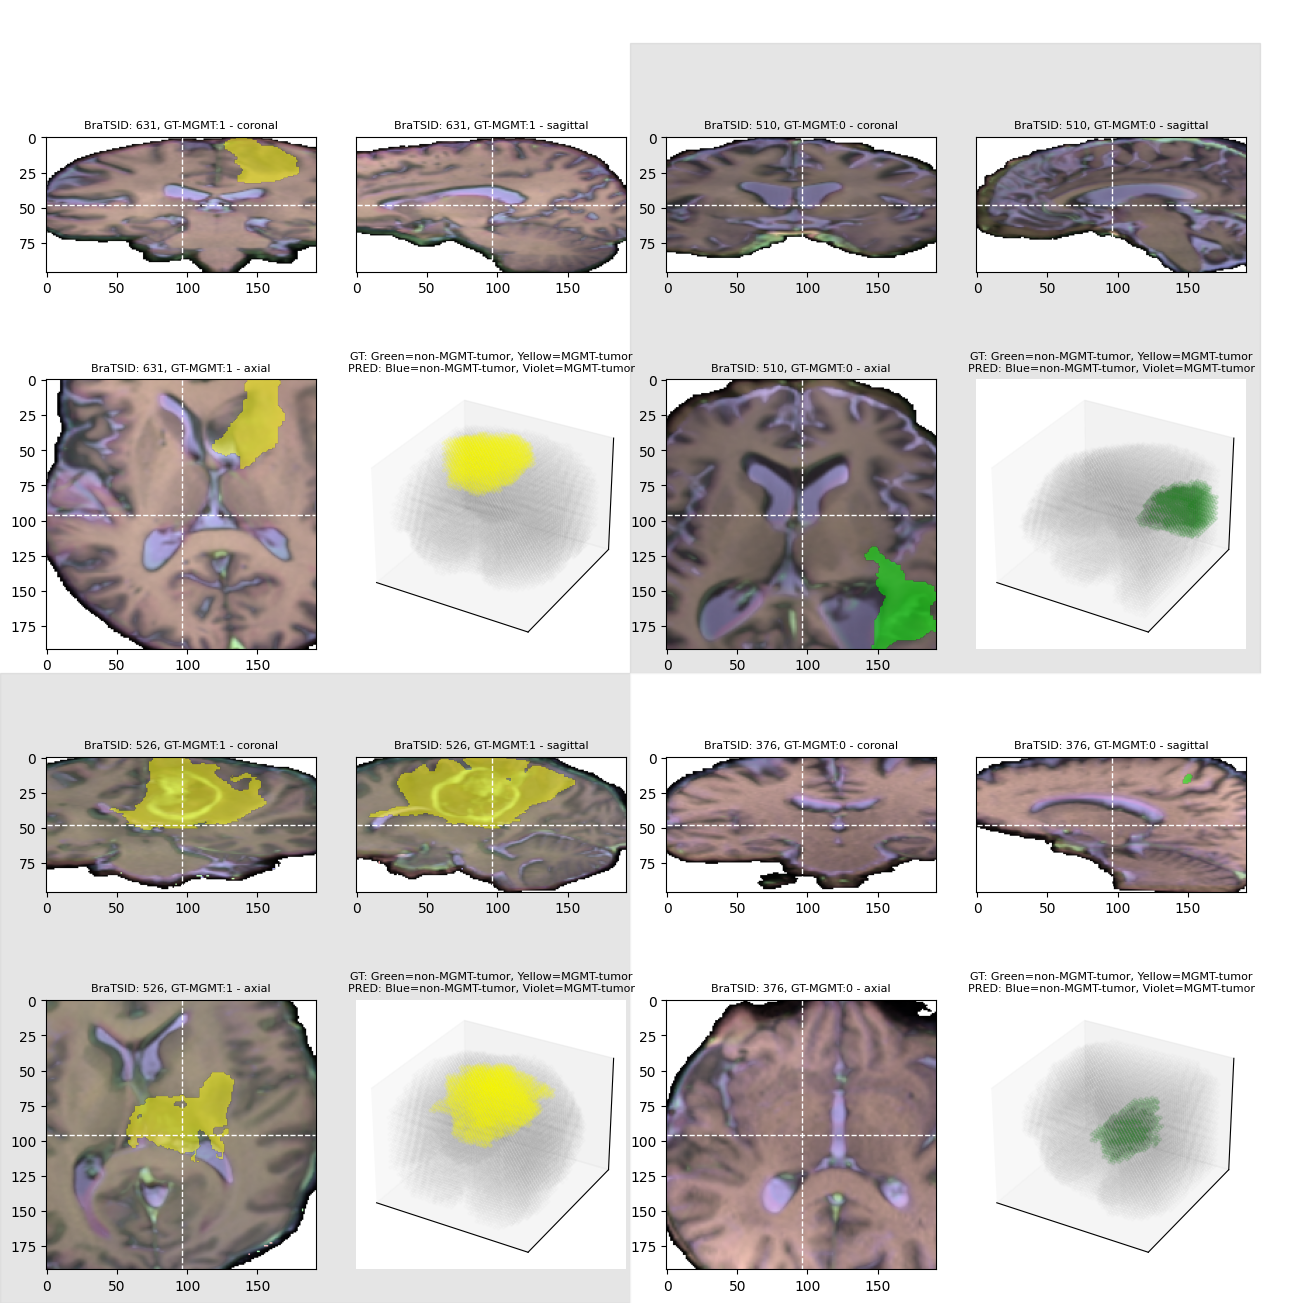

In [13]:
show_mri_sample(batch)

## Model

In [14]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn

class BaseModel(nn.Module, ABC):
    r"""
    BaseModel with basic functionalities for checkpointing and restoration.
    """

    def __init__(self):
        super().__init__()
        self.best_loss = 1000000

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def test(self):
        """
        To be implemented by the subclass so that
        models can perform a forward propagation
        :return:
        """
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def restore_checkpoint(self, ckpt_file, optimizer=None):
        r"""
        Restores checkpoint from a pth file and restores optimizer state.

        Args:
            ckpt_file (str): A PyTorch pth file containing model weights.
            optimizer (Optimizer): A vanilla optimizer to have its state restored from.

        Returns:
            int: Global step variable where the model was last checkpointed.
        """
        if not ckpt_file:
            raise ValueError("No checkpoint file to be restored.")

        try:
            ckpt_dict = torch.load(ckpt_file)
        except RuntimeError:
            ckpt_dict = torch.load(ckpt_file, map_location=lambda storage, loc: storage)
        # Restore model weights
        self.load_state_dict(ckpt_dict['model_state_dict'])

        # Restore optimizer status if existing. Evaluation doesn't need this
        # TODO return optimizer?????
        if optimizer:
            optimizer.load_state_dict(ckpt_dict['optimizer_state_dict'])

        # Return global step
        return ckpt_dict['epoch']

    def save_checkpoint(self,
                        directory,
                        epoch, loss,
                        optimizer=None,
                        name=None):
        r"""
        Saves checkpoint at a certain global step during training. Optimizer state
        is also saved together.

        Args:
            directory (str): Path to save checkpoint to.
            epoch (int): The training. epoch
            optimizer (Optimizer): Optimizer state to be saved concurrently.
            name (str): The name to save the checkpoint file as.

        Returns:
            None
        """
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':
                self.state_dict(),
            'optimizer_state_dict':
                optimizer.state_dict() if optimizer is not None else None,
            'epoch':
                epoch
        }

        # Save the file with specific name
        if name is None:
            name = "{}_{}_epoch.pth".format(
                os.path.basename(directory),  # netD or netG
                'last')

        torch.save(ckpt_dict, os.path.join(directory, name))
        if self.best_loss > loss:
            self.best_loss = loss
            name = "{}_BEST.pth".format(
                os.path.basename(directory))
            torch.save(ckpt_dict, os.path.join(directory, name))

    def count_params(self):
        r"""
        Computes the number of parameters in this model.

        Args: None

        Returns:
            int: Total number of weight parameters for this model.
            int: Total number of trainable parameters for this model.

        """
        num_total_params = sum(p.numel() for p in self.parameters())
        num_trainable_params = sum(p.numel() for p in self.parameters()
                                   if p.requires_grad)

        return num_total_params, num_trainable_params

    def inference(self, input_tensor):
        self.eval()
        with torch.no_grad():
            output = self.forward(input_tensor)
            if isinstance(output, tuple):
                output = output[0]
            return output.cpu().detach()

In [15]:
from torchsummary import summary

class UNet3D(BaseModel):
    """
    Implementations based on the Unet3D paper: https://arxiv.org/abs/1606.06650
    """

    def __init__(self, in_channels, n_classes, base_n_filter=8):
        super(UNet3D, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        self.dropout3d = nn.Dropout3d(p=0.6)
        self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
        self.softmax = nn.Softmax(dim=1)

        self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1,
                                     bias=False)
        self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
        self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

        self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter * 2, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter * 2, self.base_n_filter * 2)
        self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter * 2)

        self.conv3d_c3 = nn.Conv3d(self.base_n_filter * 2, self.base_n_filter * 4, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter * 4, self.base_n_filter * 4)
        self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter * 4)

        self.conv3d_c4 = nn.Conv3d(self.base_n_filter * 4, self.base_n_filter * 8, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter * 8, self.base_n_filter * 8)
        self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter * 8)

        self.conv3d_c5 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 16, kernel_size=3, stride=2, padding=1,
                                   bias=False)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter * 16, self.base_n_filter * 16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 16,
                                                                                             self.base_n_filter * 8)

        self.conv3d_l0 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 8, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter * 8)

        self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter * 16, self.base_n_filter * 16)
        self.conv3d_l1 = nn.Conv3d(self.base_n_filter * 16, self.base_n_filter * 8, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 8,
                                                                                             self.base_n_filter * 4)

        self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter * 8, self.base_n_filter * 8)
        self.conv3d_l2 = nn.Conv3d(self.base_n_filter * 8, self.base_n_filter * 4, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 4,
                                                                                             self.base_n_filter * 2)

        self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter * 4, self.base_n_filter * 4)
        self.conv3d_l3 = nn.Conv3d(self.base_n_filter * 4, self.base_n_filter * 2, kernel_size=1, stride=1, padding=0,
                                   bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter * 2,
                                                                                             self.base_n_filter)

        self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter * 2, self.base_n_filter * 2)
        self.conv3d_l4 = nn.Conv3d(self.base_n_filter * 2, self.n_classes, kernel_size=1, stride=1, padding=0,
                                   bias=False)

        self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter * 8, self.n_classes, kernel_size=1, stride=1, padding=0,
                                        bias=False)
        self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter * 4, self.n_classes, kernel_size=1, stride=1, padding=0,
                                        bias=False)
        self.sigmoid = nn.Sigmoid()

    def conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def norm_lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # should be feat_in*2 or feat_in
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def forward(self, x):
        #  Level 1 context pathway
        out = self.conv3d_c1_1(x)
        residual_1 = out
        out = self.lrelu(out)
        out = self.conv3d_c1_2(out)
        out = self.dropout3d(out)
        out = self.lrelu_conv_c1(out)
        # Element Wise Summation
        out += residual_1
        context_1 = self.lrelu(out)
        out = self.inorm3d_c1(out)
        out = self.lrelu(out)

        # Level 2 context pathway
        out = self.conv3d_c2(out)
        residual_2 = out
        out = self.norm_lrelu_conv_c2(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c2(out)
        out += residual_2
        out = self.inorm3d_c2(out)
        out = self.lrelu(out)
        context_2 = out

        # Level 3 context pathway
        out = self.conv3d_c3(out)
        residual_3 = out
        out = self.norm_lrelu_conv_c3(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c3(out)
        out += residual_3
        out = self.inorm3d_c3(out)
        out = self.lrelu(out)
        context_3 = out

        # Level 4 context pathway
        out = self.conv3d_c4(out)
        residual_4 = out
        out = self.norm_lrelu_conv_c4(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c4(out)
        out += residual_4
        out = self.inorm3d_c4(out)
        out = self.lrelu(out)
        context_4 = out

        # Level 5
        out = self.conv3d_c5(out)
        residual_5 = out
        out = self.norm_lrelu_conv_c5(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c5(out)
        out += residual_5
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

        out = self.conv3d_l0(out)
        out = self.inorm3d_l0(out)
        out = self.lrelu(out)

        # Level 1 localization pathway
        out = torch.cat([out, context_4], dim=1)
        out = self.conv_norm_lrelu_l1(out)
        out = self.conv3d_l1(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

        # Level 2 localization pathway
        # print(out.shape)
        # print(context_3.shape)
        out = torch.cat([out, context_3], dim=1)
        out = self.conv_norm_lrelu_l2(out)
        ds2 = out
        out = self.conv3d_l2(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

        # Level 3 localization pathway
        out = torch.cat([out, context_2], dim=1)
        out = self.conv_norm_lrelu_l3(out)
        ds3 = out
        out = self.conv3d_l3(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

        # Level 4 localization pathway
        out = torch.cat([out, context_1], dim=1)
        out = self.conv_norm_lrelu_l4(out)
        out_pred = self.conv3d_l4(out)

        ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
        ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
        ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
        ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
        ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

        out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
        seg_layer = out
        return seg_layer
    
    def test(self,device='cpu'):

        input_tensor = torch.rand(1, 2, 32, 32, 32)
        ideal_out = torch.rand(1, self.n_classes, 32, 32, 32)
        out = self.forward(input_tensor)
        assert ideal_out.shape == out.shape
        summary(self.to(torch.device(device)), (2, 32, 32, 32),device='cpu')
        # import torchsummaryX
        # torchsummaryX.summary(self, input_tensor.to(device))
        print("Unet3D test is complete")

In [16]:
model = UNet3D(in_channels=3, n_classes=2, base_n_filter=8)

In [17]:
model = model.cuda()

In [18]:
#preds = model(batch['image'].cuda())
#show_mri_sample(batch, pred_mask=preds.detach())

## Optim

In [19]:
import torch.optim as optim

optimizer_name = 'sgd'
lr=1e-2
weight_decay = 0.0000000001

if optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=weight_decay)
elif optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

## Loss (3D segmentation)

In [20]:
# Code was adapted and mofified from https://github.com/wolny/pytorch-3dunet/blob/master/pytorch3dunet/unet3d/losses.py


class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, sigmoid_normalization=True):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.classes = None
        self.skip_index_after = None
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def skip_target_channels(self, target, index):
        """
        Assuming dim 1 is the classes dim , it skips all the indexes after the desired class
        """
        assert index >= 2
        return target[:, 0:index, ...]

    def forward(self, input, target):
        """
        Expand to one hot added extra for consistency reasons
        """
        target = expand_as_one_hot(target.long(), self.classes)

        assert input.dim() == target.dim() == 5, "'input' and 'target' have different number of dims"

        if self.skip_index_after is not None:
            before_size = target.size()
            target = self.skip_target_channels(target, self.skip_index_after)
            print("Target {} after skip index {}".format(before_size, target.size()))

        assert input.size() == target.size(), "'input' and 'target' must have the same shape"
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        loss = (1. - torch.mean(per_channel_dice))
        per_channel_dice = per_channel_dice.detach().cpu().numpy()

        # average Dice score across all channels/classes
        return loss, per_channel_dice

def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    if input.dim() == 5:
        return input
    assert input.dim() == 4

    # expand the input tensor to Nx1xDxHxW before scattering
    input = input.unsqueeze(1)
    # create result tensor shape (NxCxDxHxW)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the lib tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)
    
def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)
    
def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.

    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))

class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    """

    def __init__(self, classes=2, skip_index_after=None, weight=None, sigmoid_normalization=True ):
        super().__init__(weight, sigmoid_normalization)
        self.classes = classes
        if skip_index_after is not None:
            self.skip_index_after = skip_index_after

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)

In [21]:
loss = DiceLoss(classes=2)

## Logger

In [22]:
from torch.utils.tensorboard import SummaryWriter

import time
import shutil

def datestr():
    now = time.gmtime()
    return '{:02}_{:02}___{:02}_{:02}'.format(now.tm_mday, now.tm_mon, now.tm_hour, now.tm_min)

def make_dirs(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

class TensorboardWriter():

    def __init__(self, args):

        name_model = args['log_dir'] + args['model'] + "_" + args['dataset_name'] + "_" + datestr()
        self.writer = SummaryWriter(log_dir=args['log_dir'] + name_model, comment=name_model)

        make_dirs(args['save'])
        self.csv_train, self.csv_val = self.create_stats_files(args['save'])
        self.dataset_name = args['dataset_name']
        self.classes = args['classes']
        self.label_names = args['class_names']

        self.data = self.create_data_structure()

    def create_data_structure(self, ):
        data = {"train": dict((label, 0.0) for label in self.label_names),
                "val": dict((label, 0.0) for label in self.label_names)}
        data['train']['loss'] = 0.0
        data['val']['loss'] = 0.0
        data['train']['count'] = 1.0
        data['val']['count'] = 1.0
        data['train']['dsc'] = 0.0
        data['val']['dsc'] = 0.0
        return data

    def display_terminal(self, iter, epoch, mode='train', summary=False):
        """

        :param iter: iteration or partial epoch
        :param epoch: epoch of training
        :param loss: any loss numpy
        :param mode: train or val ( for training and validation)
        :param summary: to print total statistics at the end of epoch
        """
        if summary:
            info_print = "\nSummary {} Epoch {:2d}:  Loss:{:.4f} \t DSC:{:.4f}  ".format(mode, epoch,
                                                                                         self.data[mode]['loss'] /
                                                                                         self.data[mode]['count'],
                                                                                         self.data[mode]['dsc'] /
                                                                                         self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{} : {:.4f}".format(self.label_names[i],
                                                     self.data[mode][self.label_names[i]] / self.data[mode]['count'])

            print(info_print)
        else:

            info_print = "\nEpoch: {:.2f} Loss:{:.4f} \t DSC:{:.4f}".format(iter, self.data[mode]['loss'] /
                                                                            self.data[mode]['count'],
                                                                            self.data[mode]['dsc'] /
                                                                            self.data[mode]['count'])

            for i in range(len(self.label_names)):
                info_print += "\t{}:{:.4f}".format(self.label_names[i],
                                                   self.data[mode][self.label_names[i]] / self.data[mode]['count'])
            print(info_print)

    def create_stats_files(self, path):
        train_f = open(os.path.join(path, 'train.csv'), 'w')
        val_f = open(os.path.join(path, 'val.csv'), 'w')
        return train_f, val_f

    def reset(self, mode):
        self.data[mode]['dsc'] = 0.0
        self.data[mode]['loss'] = 0.0
        self.data[mode]['count'] = 1
        for i in range(len(self.label_names)):
            self.data[mode][self.label_names[i]] = 0.0

    def update_scores(self, iter, loss, channel_score, mode, writer_step):
        """
        :param iter: iteration or partial epoch
        :param loss: any loss torch.tensor.item()
        :param channel_score: per channel score or dice coef
        :param mode: train or val ( for training and validation)
        :param writer_step: tensorboard writer step
        """
        # WARNING ASSUMING THAT CHANNELS IN SAME ORDER AS DICTIONARY

        dice_coeff = np.mean(channel_score) * 100

        num_channels = len(channel_score)
        self.data[mode]['dsc'] += dice_coeff
        self.data[mode]['loss'] += loss
        self.data[mode]['count'] = iter + 1

        for i in range(num_channels):
            self.data[mode][self.label_names[i]] += channel_score[i]
            if self.writer is not None:
                self.writer.add_scalar(mode + '/' + self.label_names[i], channel_score[i], global_step=writer_step)

    def write_end_of_epoch(self, epoch):

        self.writer.add_scalars('DSC/', {'train': self.data['train']['dsc'] / self.data['train']['count'],
                                         'val': self.data['val']['dsc'] / self.data['val']['count'],
                                         }, epoch)
        self.writer.add_scalars('Loss/', {'train': self.data['train']['loss'] / self.data['train']['count'],
                                          'val': self.data['val']['loss'] / self.data['val']['count'],
                                          }, epoch)
        for i in range(len(self.label_names)):
            self.writer.add_scalars(self.label_names[i],
                                    {'train': self.data['train'][self.label_names[i]] / self.data['train']['count'],
                                     'val': self.data['val'][self.label_names[i]] / self.data['train']['count'],
                                     }, epoch)

        train_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch,
                                                                     self.data['train']['loss'] / self.data['train'][
                                                                         'count'],
                                                                     self.data['train']['dsc'] / self.data['train'][
                                                                         'count'])
        val_csv_line = 'Epoch:{:2d} Loss:{:.4f} DSC:{:.4f}'.format(epoch,
                                                                   self.data['val']['loss'] / self.data['val'][
                                                                       'count'],
                                                                   self.data['val']['dsc'] / self.data['val'][
                                                                       'count'])
        self.csv_train.write(train_csv_line + '\n')
        self.csv_val.write(val_csv_line + '\n')


## Trainer

In [23]:
class BraTS2021_Trainer:
    """
    Trainer class
    """

    def __init__(self, args, model, criterion, optimizer, train_data_loader,
                 valid_data_loader=None, lr_scheduler=None):

        self.args = args
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_data_loader = train_data_loader
        # epoch-based training
        self.len_epoch = len(self.train_data_loader)
        self.valid_data_loader = valid_data_loader
        self.do_validation = self.valid_data_loader is not None
        self.lr_scheduler = lr_scheduler
        self.log_step = int(np.sqrt(train_data_loader.batch_size))
        self.writer = TensorboardWriter(args)

        self.save_frequency = 10
        self.terminal_show_freq = 50
        self.start_epoch = 1

    def training(self):
        for epoch in range(self.start_epoch, self.args['nEpochs']):
            self.train_epoch(epoch)

            if self.do_validation:
                self.validate_epoch(epoch)

            val_loss = self.writer.data['val']['loss'] / self.writer.data['val']['count']

            if self.args['save'] is not None and ((epoch + 1) % self.save_frequency):
                self.model.save_checkpoint(self.args['save'],
                                           epoch, val_loss,
                                           optimizer=self.optimizer)

            self.writer.write_end_of_epoch(epoch)

            self.writer.reset('train')
            self.writer.reset('val')

    def train_epoch(self, epoch):
        self.model.train()

        for batch_idx, input_samples in enumerate(self.train_data_loader):

            self.optimizer.zero_grad()

            input_tensor, target = input_samples['image'], input_samples['segmentation']
            input_tensor, target = input_tensor.to(self.device), target.to(self.device)
            
            input_tensor.requires_grad = True
            output = self.model(input_tensor)
            loss_dice, per_ch_score = self.criterion(output, target)
            loss_dice.backward()
            self.optimizer.step()

            self.writer.update_scores(batch_idx, loss_dice.item(), per_ch_score, 'train',
                                      epoch * self.len_epoch + batch_idx)

            if (batch_idx + 1) % self.terminal_show_freq == 0:
                partial_epoch = epoch + batch_idx / self.len_epoch - 1
                self.writer.display_terminal(partial_epoch, epoch, 'train')

        self.writer.display_terminal(self.len_epoch, epoch, mode='train', summary=True)

    def validate_epoch(self, epoch):
        self.model.eval()

        for batch_idx, input_samples in enumerate(self.valid_data_loader):
            with torch.no_grad():
                input_tensor, target = input_samples['image'], input_samples['segmentation']
                input_tensor, target = input_tensor.to(self.device), target.to(self.device)
                
                input_tensor.requires_grad = False

                output = self.model(input_tensor)
                loss, per_ch_score = self.criterion(output, target)

                self.writer.update_scores(batch_idx, loss.item(), per_ch_score, 'val',
                                          epoch * self.len_epoch + batch_idx)

        self.writer.display_terminal(len(self.valid_data_loader), epoch, mode='val', summary=True)


In [24]:
train_args = {
    'nEpochs' : 10, # 100
    'classes' : 2,
    'class_names' : ['non-MGMT-tumor','MGMT-tumor'],
    'inChannels' : 3,
    'log_dir' : '../runs/',
    'save': '../output/test',
    'model':'unet3d',
    'dataset_name':'registeredv1'
}
trainer = BraTS2021_Trainer(train_args, model, loss, optimizer, train_data_loader=train_generator,
                            valid_data_loader=val_generator)
trainer.training()


Epoch: 0.43 Loss:0.9052 	 DSC:9.4834	non-MGMT-tumor:0.0773	MGMT-tumor:0.1123

Epoch: 0.86 Loss:0.8724 	 DSC:12.7557	non-MGMT-tumor:0.0946	MGMT-tumor:0.1605

Summary train Epoch  1:  Loss:0.8579 	 DSC:14.2055  	non-MGMT-tumor : 0.1013	MGMT-tumor : 0.1828


RuntimeError: Sizes of tensors must match except in dimension 4. Got 13 and 14 (The offending index is 0)